In [1]:
!pip install pytorch_lightning
!pip install neuralforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.2/812.2 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 23.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-many

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import Autoformer
from neuralforecast.losses.pytorch import MAE
from google.colab import files
uploaded = files.upload()

Saving viettri_quality.csv to viettri_quality.csv


In [3]:
data = pd.read_csv('viettri_quality.csv')

# Thay thế cột 'date' bằng chỉ số từ 0 đến N-1
data['index'] = np.arange(len(data))

# Chuẩn bị dữ liệu cho mô hình
data['unique_id'] = 'pm25'
data['y'] = data['pm25']
data['ds'] = data['index']

def smoothed(data):
    # Áp dụng bộ lọc trung bình động để làm mượt các giá trị dự báo
    window_size = 5
    forecast_smoothed = data.rolling(window=window_size).mean()

    # Nội suy các giá trị NaN kết quả từ trung bình động
    forecast_smoothed_interpolated = forecast_smoothed.interpolate()

    # Điền các giá trị NaN còn lại
    forecast_smoothed_filled = forecast_smoothed_interpolated.fillna(method='bfill')  # hoặc 'ffill', hoặc dùng fillna(value=0)

    return forecast_smoothed_filled

# Làm mượt dữ liệu
data['y_smooth'] = smoothed(data['y'])

# Chia dữ liệu thành train và test theo tỉ lệ 7:3
split_idx = int(len(data) * 0.7)
train_data = data[:split_idx].copy()
test_data = data[split_idx:].copy()

# Chỉ giữ lại các cột cần thiết
train_data = train_data[['unique_id', 'ds', 'y_smooth']].rename(columns={'y_smooth': 'y'})
test_data = test_data[['unique_id', 'ds', 'y_smooth']].rename(columns={'y_smooth': 'y'})

In [4]:
# Khởi tạo và huấn luyện mô hình
import torch
model = Autoformer(
    h=len(test_data),  # forecast horizon
    input_size=30,  # maximum sequence length
    hidden_size=16,  # units of embeddings and encoders
    conv_hidden_size=32,  # channels of the convolutional encoder
    n_head=1,  # number of multi-head's attention
    loss=MAE(),  # loss function
    futr_exog_list=[],  # no future exogenous columns
    scaler_type='robust',  # type of scaler for temporal inputs normalization
    learning_rate=1e-3,  # learning rate
    max_steps=100,  # maximum number of training steps
    optimizer=torch.optim.Adam  # optimizer
)

nf = NeuralForecast(
    models=[model],
    freq=1  # tần suất của dữ liệu chuỗi thời gian
)

nf.fit(df=train_data)

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | enc_embedding | DataEmbedding | 48     | train
5 | dec_embedding | DataEmbedding | 48     | train
6 | encoder       | Encoder       | 4.3 K  | train
7 | decoder       | Decoder       | 3.3 K  | train
--------------------------------------------------------
7.6 K     Trainable params
0         Non-trainable params
7.6 K     Total params
0.031  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.


In [5]:
# Dự đoán trên tập test
forecasts = nf.predict(futr_df=test_data)
predictions = forecasts['Autoformer'].values

# Smooth the predictions
predictions_smoothed = smoothed(pd.Series(predictions)).values

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [6]:
# Đánh giá mô hình
y_true = test_data['y'].values
y_pred = predictions_smoothed

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

RMSE: 22.472276580198177
MAE: 16.91413434743881
MAPE: 43.81564529337258


In [7]:
model = Autoformer(
    h=90,  # forecast horizon
    input_size=30,  # maximum sequence length (Sử dụng 30 bước thời gian trước đó làm đầu vào.)
    hidden_size=16,  # units of embeddings and encoders
    conv_hidden_size=32,  # channels of the convolutional encoder
    n_head=1,  # number of multi-head's attention
    loss=MAE(),  # loss function
    futr_exog_list=[],  # no future exogenous columns
    scaler_type='robust',  # type of scaler for temporal inputs normalization
    learning_rate=1e-3,  # learning rate
    max_steps=100,  # maximum number of training steps
    optimizer=torch.optim.Adam  # optimizer
)

nf = NeuralForecast(
    models=[model],
    freq=1  # tần suất của dữ liệu chuỗi thời gian
)

# Chỉ giữ lại các cột cần thiết
data = data[['unique_id', 'ds', 'y']]

nf.fit(df=data)

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | enc_embedding | DataEmbedding | 48     | train
5 | dec_embedding | DataEmbedding | 48     | train
6 | encoder       | Encoder       | 4.3 K  | train
7 | decoder       | Decoder       | 3.3 K  | train
--------------------------------------------------------
7.6 K     Trainable params
0         Non-trainable params
7.6 K     Total params
0.031  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.


In [8]:
future_data = pd.DataFrame({
    'unique_id': ['pm25'] * 90,
    'ds': np.arange(len(data), len(data) + 90),
    'y': [np.nan] * 90
})

# Dự báo 90 ngày tiếp theo
forecasts = nf.predict(futr_df=future_data)
future_predictions = forecasts['Autoformer'].values

# Tách dữ liệu dự đoán thành 3 phần
future_predictions_1_30 = future_predictions[:30]
future_predictions_31_60 = future_predictions[30:60]
future_predictions_61_90 = future_predictions[60:]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [9]:
# In ra các dự đoán
print("90D Predictions:")
print(future_predictions)

90D Predictions:
[22.022491 21.527344 23.161188 23.857246 23.996996 23.335869 22.229002
 22.67706  25.542423 25.580595 25.123283 23.169764 23.29201  24.548296
 23.77886  23.411564 23.201508 22.150791 22.77794  22.94888  22.232704
 23.744133 24.355652 24.14559  23.548943 24.265476 24.207008 24.34682
 24.761415 24.291546 23.697945 23.761147 23.596458 23.159773 23.056831
 23.084538 22.780184 22.828825 23.059156 23.0364   23.25057  23.676626
 24.006983 25.023531 25.015965 25.013182 24.942503 24.894108 24.932306
 24.808756 24.43994  24.081627 23.786888 23.591131 23.582317 23.577059
 23.55695  23.530909 23.49761  23.456223 23.40713  23.357391 23.332169
 23.337172 23.34416  23.369738 23.421383 23.525923 23.75127  24.035038
 24.09867  24.099482 24.104776 24.092049 24.005953 23.935863 23.934593
 23.960123 23.964294 23.78596  23.35691  23.310263 23.261139 23.225584
 23.192272 23.219381 23.403467 23.489012 23.279268 23.199898]


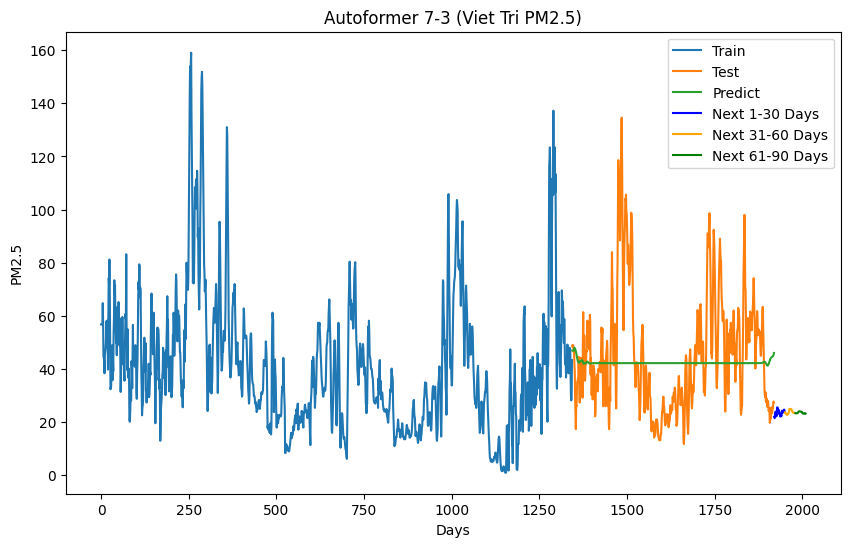

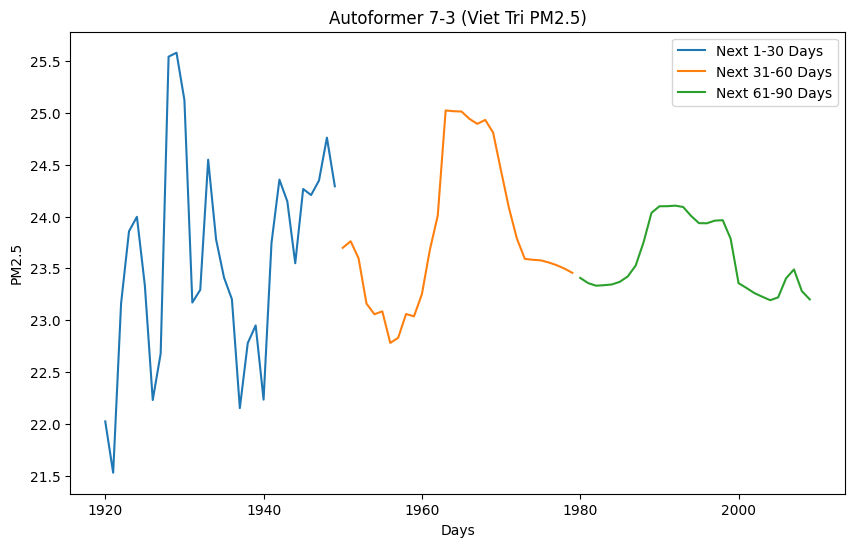

In [10]:
# Vẽ đồ thị
plt.figure(figsize=(10, 6))
plt.plot(train_data['ds'], train_data['y'], label='Train')
plt.plot(test_data['ds'], test_data['y'], label='Test')
plt.plot(test_data['ds'], y_pred, label='Predict')
plt.plot(np.arange(len(data), len(data) + 30), future_predictions_1_30, color='blue', label='Next 1-30 Days')
plt.plot(np.arange(len(data) + 30, len(data) + 60), future_predictions_31_60, color='orange', label='Next 31-60 Days')
plt.plot(np.arange(len(data) + 60, len(data) + 90), future_predictions_61_90, color='green', label='Next 61-90 Days')
plt.legend()
plt.xlabel('Days')
plt.ylabel('PM2.5')
plt.title('Autoformer 7-3 (Viet Tri PM2.5)')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(data), len(data) + 30), future_predictions_1_30, color='tab:blue', label='Next 1-30 Days')
plt.plot(np.arange(len(data) + 30, len(data) + 60), future_predictions_31_60, color='tab:orange', label='Next 31-60 Days')
plt.plot(np.arange(len(data) + 60, len(data) + 90), future_predictions_61_90, color='tab:green', label='Next 61-90 Days')
plt.legend()
plt.xlabel('Days')
plt.ylabel('PM2.5')
plt.title('Autoformer 7-3 (Viet Tri PM2.5)')
plt.show()